In [1]:
import pandas as pd
from graphing_functions import *
from utils import *


In [2]:
experiment_name = "2-by-4-PE-varying-sparsity-and-compression"
run_mapper = False
has_original = False
output_dir = os.getcwd()

In [3]:
eyerissv2_pe_config_file = os.path.join(
    os.getcwd(),
    f"{experiment_name}/design/SI-SW.yaml"
)
print(f"config file = {eyerissv2_pe_config_file}")

config file = /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/design/SI-SW.yaml


In [4]:
eyerissv2_pe_arch_file = os.path.join(
    os.getcwd(),
    f"{experiment_name}/design/arch.yaml"
)
print(f"arch file = {eyerissv2_pe_arch_file}")

arch file = /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/design/arch.yaml


In [5]:
eyerissv2_pe_component_file = os.path.join(
    os.getcwd(),
    f"{experiment_name}/design/compound_components.yaml"
)
print(f"component file = {eyerissv2_pe_component_file}")

component file = /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/design/compound_components.yaml


In [6]:
mobilenet_sparse_dir = os.path.join(
    os.getcwd(),
    f"workloads/mobilenet0.5-sparse/{experiment_name}"
)
print(f"workloads dir = {mobilenet_sparse_dir}")

workloads dir = /home/workspace/2022.micro.artifact/notebook/workloads/mobilenet0.5-sparse/2-by-4-PE-varying-sparsity-and-compression


In [7]:
mobilenet_sparse_mappings_dir = os.path.join(
    os.getcwd(),
    f"{experiment_name}/mapping/original-derived-mapping"
)
print(f"mappings dir = {mobilenet_sparse_mappings_dir}")

mappings dir = /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/mapping/original-derived-mapping


In [8]:
mobilenet_computed_sparse_mappings_dir = os.path.join(
    os.getcwd(),
    f"{experiment_name}/mapping/searched-mapping"
)
print(f"searched mappings dir = {mobilenet_computed_sparse_mappings_dir}")

searched mappings dir = /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/mapping/searched-mapping


In [9]:
experiment_ertart_dir = f"{experiment_name}/ert_art/"
eyerissv2_pe_art_file = os.path.join(
    os.getcwd(),
    experiment_ertart_dir + "ART.yaml"
)
eyerissv2_pe_ert_file = os.path.join(
    os.getcwd(),
    experiment_ertart_dir + "ERT.yaml"
)
print(f"art file = {eyerissv2_pe_art_file}")
print(f"ert file = {eyerissv2_pe_ert_file}")

art file = /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/ert_art/ART.yaml
ert file = /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/ert_art/ERT.yaml


In [10]:
mapper_file = os.path.join(
    os.getcwd(),
    f"{experiment_name}/mapper/mapper.yaml"
)
print(f"mapper file = {mapper_file}")

mapper file = /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/mapper/mapper.yaml


In [11]:
constraints_file = os.path.join(
    os.getcwd(),
    f"{experiment_name}/mapper/constraints.yaml"
)
print(f"constraints file = {constraints_file}")

constraints file = /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/mapper/constraints.yaml


In [12]:
workload_file_array = get_all_files_in_dir(mobilenet_sparse_dir)
mapping_file_array = get_all_files_in_dir(mobilenet_sparse_mappings_dir)
computed_mapping_file_array = get_all_files_in_dir(mobilenet_computed_sparse_mappings_dir)

print(workload_file_array)

['/home/workspace/2022.micro.artifact/notebook/workloads/mobilenet0.5-sparse/2-by-4-PE-varying-sparsity-and-compression/L07_sparse=0.1.yaml', '/home/workspace/2022.micro.artifact/notebook/workloads/mobilenet0.5-sparse/2-by-4-PE-varying-sparsity-and-compression/L07_sparse=0.2.yaml', '/home/workspace/2022.micro.artifact/notebook/workloads/mobilenet0.5-sparse/2-by-4-PE-varying-sparsity-and-compression/L07_sparse=0.3.yaml', '/home/workspace/2022.micro.artifact/notebook/workloads/mobilenet0.5-sparse/2-by-4-PE-varying-sparsity-and-compression/L07_sparse=0.4.yaml', '/home/workspace/2022.micro.artifact/notebook/workloads/mobilenet0.5-sparse/2-by-4-PE-varying-sparsity-and-compression/L07_sparse=0.5.yaml', '/home/workspace/2022.micro.artifact/notebook/workloads/mobilenet0.5-sparse/2-by-4-PE-varying-sparsity-and-compression/L07_sparse=0.6.yaml', '/home/workspace/2022.micro.artifact/notebook/workloads/mobilenet0.5-sparse/2-by-4-PE-varying-sparsity-and-compression/L07_sparse=0.7.yaml', '/home/works

In [13]:
run_accelergy(
    arch=eyerissv2_pe_arch_file,
    components=eyerissv2_pe_component_file
)

    _                _                      
   / \   ___ ___ ___| | ___ _ __ __ _ _   _ 
  / _ \ / __/ __/ _ \ |/ _ \ '__/ _` | | | |
 / ___ \ (_| (_|  __/ |  __/ | | (_| | |_| |
/_/   \_\___\___\___|_|\___|_|  \__, |\__, |
                                |___/ |___/ 

Info: generating outputs according to the following specified output flags... 
 Please use the -f flag to update the preference (default to all output files) 
{'ERT': 1, 'ERT_summary': 1, 'ART': 1, 'ART_summary': 1, 'energy_estimation': 1, 'flattened_arch': 1}
Info: config file located: /home/workspace/.config/accelergy/accelergy_config.yaml 
config file content: 
 {'version': 0.3, 'compound_components': [], 'estimator_plug_ins': ['/usr/local/share/accelergy/estimation_plug_ins'], 'primitive_components': ['/usr/local/share/accelergy/primitive_component_libs'], 'table_plug_ins': {'roots': ['/usr/local/share/accelergy/estimation_plug_ins/accelergy-table-based-plug-ins/set_of_table_templates']}}
Info: Parsing file /home/wo

In [14]:
shutil.copy("ART.yaml", experiment_ertart_dir)
shutil.copy("ART_summary.yaml", experiment_ertart_dir)
shutil.copy("ERT.yaml", experiment_ertart_dir)
shutil.copy("ERT_summary.yaml", experiment_ertart_dir)
print("Copying computed ART/ERT")

Copying computed ART/ERT


In [15]:
if run_mapper:
    print("Running mapper ...")
    for workload_file in workload_file_array:
        print(workload_file)
        run_timeloop_mapper(
            arch    = eyerissv2_pe_arch_file,
            problem = workload_file, 
            mapper  = mapper_file,
            pe_art  = eyerissv2_pe_art_file,
            pe_ert  = eyerissv2_pe_ert_file,
            config  = eyerissv2_pe_config_file,
            constraints = constraints_file
        )
        workload_file_name = workload_file.strip().split('/')[-1].strip('.yaml')
        print(workload_file_name)
        mv_cmd_map = ['mv','timeloop-mapper.map.yaml',f"{experiment_name}/mapping/searched-mapping/{workload_file_name}-timeloop-mapper.map.yaml"]
        print(' '.join(mv_cmd_map))    
        status = subprocess.call(mv_cmd_map) 


In [16]:
if has_original:
    print("Running timeloop-model on original mappings ...")
    run_timeloop(
        workloads       =   workload_file_array,
        mappings        =   mapping_file_array,
        config          =   eyerissv2_pe_config_file,
        pe_art          =   eyerissv2_pe_art_file,
        pe_ert          =   eyerissv2_pe_ert_file,
        arch            =   eyerissv2_pe_arch_file,
        output_dir      =   output_dir,
        experiment_name =   experiment_name
    )


Running timeloop-model on computed mappings ...
Utilization = 1.00 | pJ/Algorithmic-Compute =    1.802 | pJ/Compute =   34.652
TIMELOOP-MODEL COMMAND:  timeloop-model /home/workspace/2022.micro.artifact/notebook/workloads/mobilenet0.5-sparse/2-by-4-PE-varying-sparsity-and-compression/L07_sparse=0.1.yaml /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/mapping/searched-mapping/L07_sparse=0.1-timeloop-mapper.map.yaml /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/design/SI-SW.yaml /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/ert_art/ART.yaml /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/ert_art/ERT.yaml /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/design/arch.yaml
Utilization = 1.00 | pJ/Algorithmic-Compute =    2.339 | pJ/Compute =   22.487
TIMELOOP-MODEL COMMAND:  timeloop-model /h

Utilization = 1.00 | pJ/Algorithmic-Compute =    5.559 | pJ/Compute =   13.363
TIMELOOP-MODEL COMMAND:  timeloop-model /home/workspace/2022.micro.artifact/notebook/workloads/mobilenet0.5-sparse/2-by-4-PE-varying-sparsity-and-compression/L07_sparse=0.8.yaml /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/mapping/searched-mapping/L07_sparse=0.8-timeloop-mapper.map.yaml /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/design/SI-SW.yaml /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/ert_art/ART.yaml /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/ert_art/ERT.yaml /home/workspace/2022.micro.artifact/notebook/2-by-4-PE-varying-sparsity-and-compression/design/arch.yaml
Utilization = 1.00 | pJ/Algorithmic-Compute =    6.096 | pJ/Compute =   13.026
TIMELOOP-MODEL COMMAND:  timeloop-model /home/workspace/2022.micro.artifact/notebook/workl

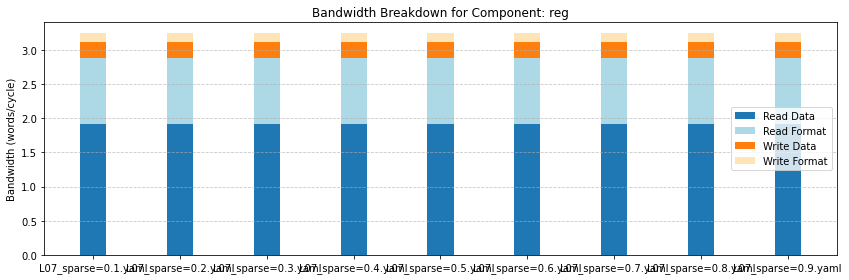

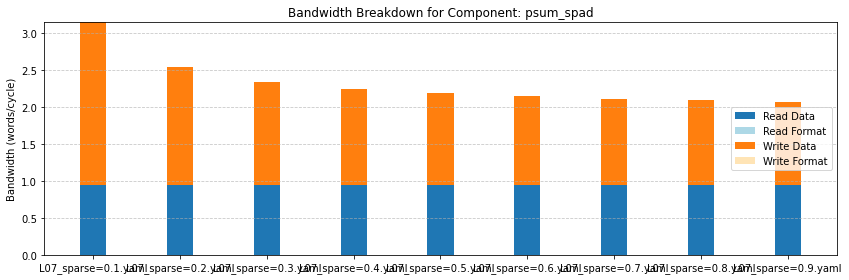

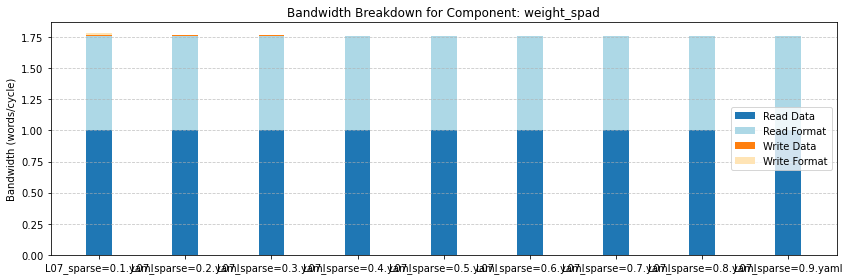

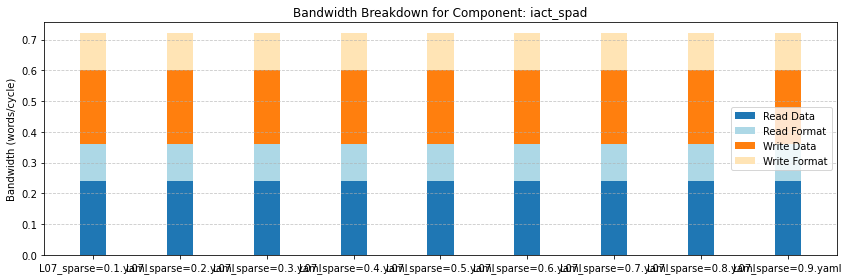

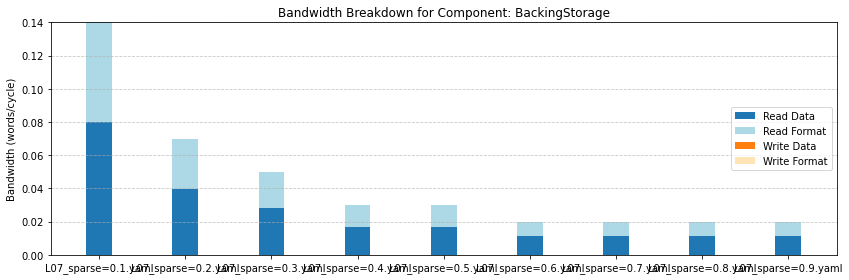

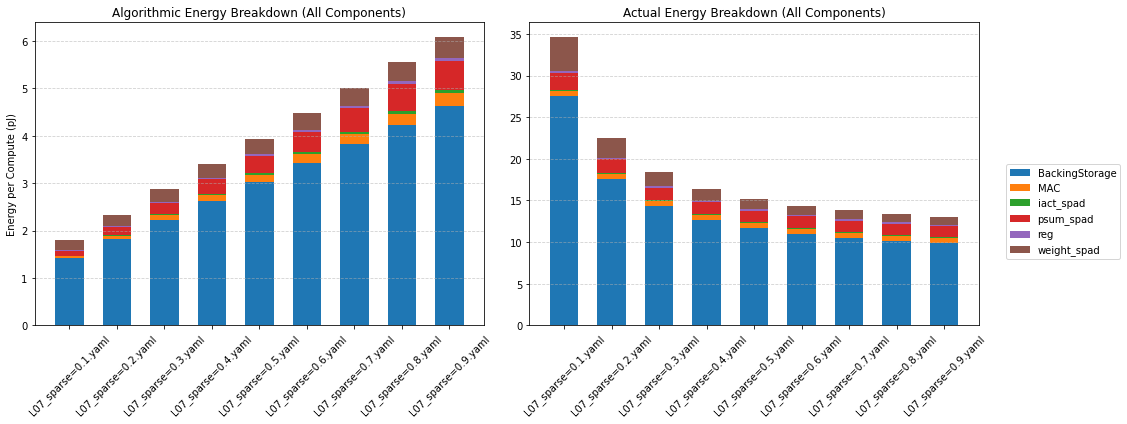

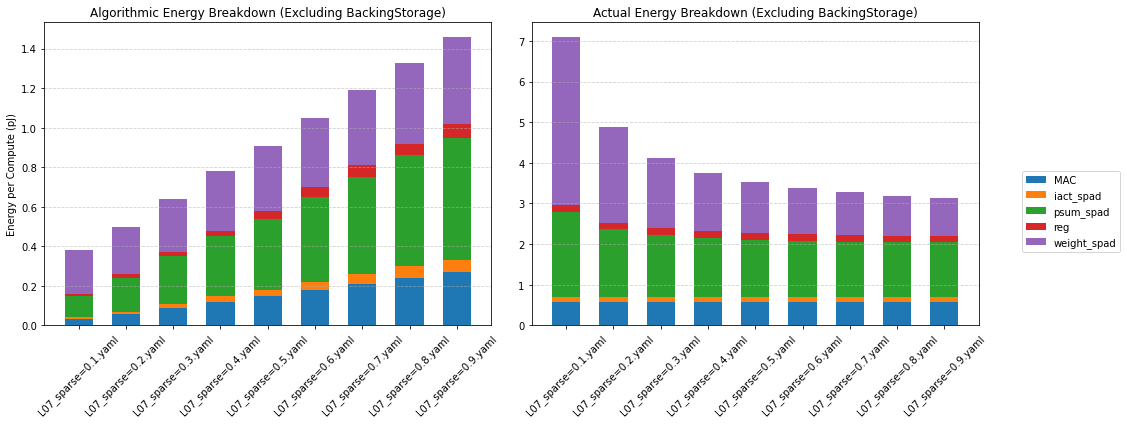

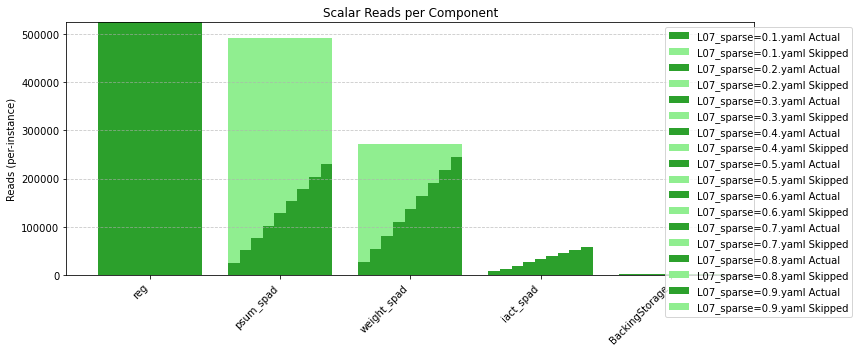

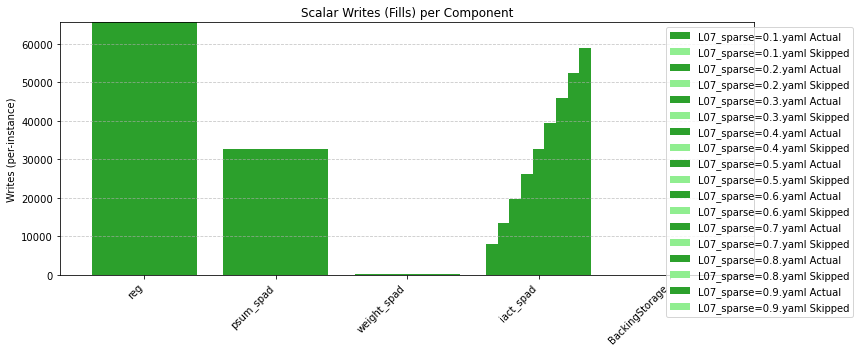

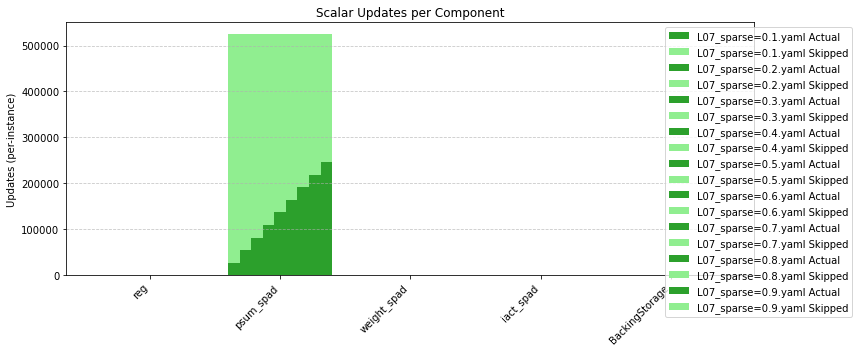

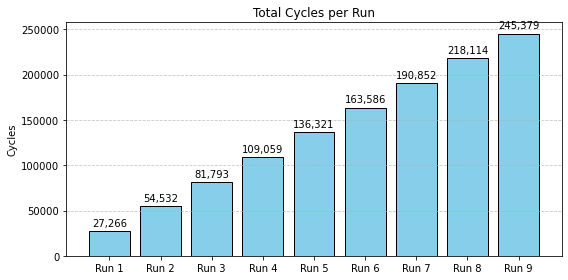

In [17]:
print("Running timeloop-model on computed mappings ...")
run_timeloop(
    workloads       =   workload_file_array,
    mappings        =   computed_mapping_file_array,
    config          =   eyerissv2_pe_config_file,
    pe_art          =   eyerissv2_pe_art_file,
    pe_ert          =   eyerissv2_pe_ert_file,
    arch            =   eyerissv2_pe_arch_file,
    output_dir      =   output_dir,
    experiment_name =   experiment_name
)


In [18]:
# experiment_name = "2-by-4-PE-varying-sparsity"
# mobilenet_sparse_dir = os.path.join(
#     os.getcwd(),
#     f"workloads/mobilenet0.5-sparse/{experiment_name}"
# )
# mobilenet_sparse_mappings_dir = os.path.join(
#     os.getcwd(),
#     f"{experiment_name}/mapping/mapping-L07-sparsity/"
# )
# mobilenet_computed_sparse_mappings_dir = os.path.join(
#     os.getcwd(),
#     f"{experiment_name}/mapping/searched-mapping"
# )


# workload_file_array = get_all_files_in_dir(mobilenet_sparse_dir) 
# mapping_file_array = get_all_files_in_dir(mobilenet_sparse_mappings_dir) * len(workload_file_array)
# computed_mapping_file_array = get_all_files_in_dir(mobilenet_computed_sparse_mappings_dir)

# for workload,mapping,computed_mapping in zip(workload_file_array,mapping_file_array,computed_mapping_file_array):
#     print(workload,mapping,computed_mapping)
#     print()
    
    

In [19]:
# mapper_file = os.path.join(
#     os.getcwd(),
#     f"{experiment_name}/mapper/mapper.yaml"
# )
# constraints_file = os.path.join(
#     os.getcwd(),
#     f"{experiment_name}/mapper/constraints.yaml"
# )



In [20]:

# for workload_file in workload_file_array:
#     run_timeloop_mapper(
#         arch    = eyerissv2_pe_arch_file,
#         problem = workload_file, 
#         mapper  = mapper_file,
#         pe_art  = eyerissv2_pe_art_file,
#         pe_ert  = eyerissv2_pe_ert_file,
#         config  = eyerissv2_pe_config_file,
#         constraints = constraints_file
#     )
#     workload_file_name = workload_file.strip().split('/')[-1].strip('.yaml')
#     print(workload_file_name)
#     mv_cmd_stat = ['mv','timeloop-mapper.stats.txt',f"{experiment_name}/mapping/searched-mapping/{workload_file_name}-timeloop-mapper.stats.txt"]
#     print(' '.join(mv_cmd_stat))    
#     status = subprocess.call(mv_cmd_stat) 
#     mv_cmd_map = ['mv','timeloop-mapper.map.yaml',workload_file_name+'-timeloop-mapper.map.yaml']
#     print(' '.join(mv_cmd_map))    
#     status = subprocess.call(mv_cmd_map) 

In [21]:
# # output_dir = os.path.join(os.getcwd(),'/debug')
# run_timeloop(
#     workloads       =   workload_file_array,
#     mappings        =   mapping_file_array,
#     config          =   eyerissv2_pe_config_file,
#     pe_art          =   eyerissv2_pe_art_file,
#     pe_ert          =   eyerissv2_pe_ert_file,
#     arch            =   eyerissv2_pe_arch_file,
#     output_dir      =   output_dir,
#     experiment_name =   experiment_name
# )


In [22]:
# # output_dir = os.path.join(os.getcwd(),'/debug')
# run_timeloop(
#     workloads       =   workload_file_array,
#     mappings        =   computed_mapping_file_array,
#     config          =   eyerissv2_pe_config_file,
#     pe_art          =   eyerissv2_pe_art_file,
#     pe_ert          =   eyerissv2_pe_ert_file,
#     arch            =   eyerissv2_pe_arch_file,
#     output_dir      =   output_dir,
#     experiment_name =   experiment_name
# )
